### VOLVE Dataset Preliminary Study - production data




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

#sysidentpy
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.general_estimators.narx import NARX
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

# Scores
from sklearn.metrics import r2_score

# multiple outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
csvfile = os.path.join(os.getcwd(), 'data', 'Volve_production_data.csv')
df = pd.read_csv(csvfile, sep=';', decimal=',')

rate_cols = ['BORE_OIL_VOL','BORE_GAS_VOL','BORE_WAT_VOL','BORE_WI_VOL']
df[rate_cols] = df[rate_cols].astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15634 entries, 0 to 15633
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DATEPRD                   15634 non-null  object 
 1   month                     15634 non-null  int64  
 2   year                      15634 non-null  int64  
 3   month-year                15634 non-null  object 
 4   WELL_BORE_CODE            15634 non-null  object 
 5   NPD_WELL_BORE_CODE        15634 non-null  int64  
 6   NPD_WELL_BORE_NAME        15634 non-null  object 
 7   NPD_FIELD_CODE            15634 non-null  int64  
 8   NPD_FIELD_NAME            15634 non-null  object 
 9   NPD_FACILITY_CODE         15634 non-null  int64  
 10  NPD_FACILITY_NAME         15634 non-null  object 
 11  ON_STREAM_HRS             15349 non-null  float64
 12  AVG_DOWNHOLE_PRESSURE     8980 non-null   float64
 13  AVG_DOWNHOLE_TEMPERATURE  8980 non-null   float64
 14  AVG_DP

In [3]:
df.insert(1,'N', df.groupby(['NPD_WELL_BORE_NAME']).cumcount())

In [146]:
filt_vars_IN_Q =  [
        'BORE_OIL_VOL',
        'BORE_GAS_VOL',
        'BORE_WAT_VOL',
]

filt_vars_IN_QINJ = [
        'BORE_WI_VOL',
]

filt_vars_IN_P = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        'AVG_DP_TUBING',
        # 'AVG_ANNULUS_PRESS',
        # 'AVG_CHOKE_SIZE_P',
        # 'AVG_CHOKE_UOM',
        # 'DP_CHOKE_SIZE',
]

filt_vars_IN_T = [
        'AVG_WHT_P',
        'AVG_DOWNHOLE_TEMPERATURE',
]

filt_vars_OUT = [
        'BORE_OIL_VOL',
]

In [147]:
wells = df['NPD_WELL_BORE_NAME'].unique()
pwells = df[df['FLOW_KIND'] == 'production']['NPD_WELL_BORE_NAME'].unique()
iwells = df[df['FLOW_KIND'] == 'injection']['NPD_WELL_BORE_NAME'].unique()

wells, pwells, iwells

(array(['15/9-F-1 C', '15/9-F-11', '15/9-F-12', '15/9-F-14', '15/9-F-15 D',
        '15/9-F-4', '15/9-F-5'], dtype=object),
 array(['15/9-F-1 C', '15/9-F-11', '15/9-F-12', '15/9-F-14', '15/9-F-15 D',
        '15/9-F-5'], dtype=object),
 array(['15/9-F-4', '15/9-F-5'], dtype=object))

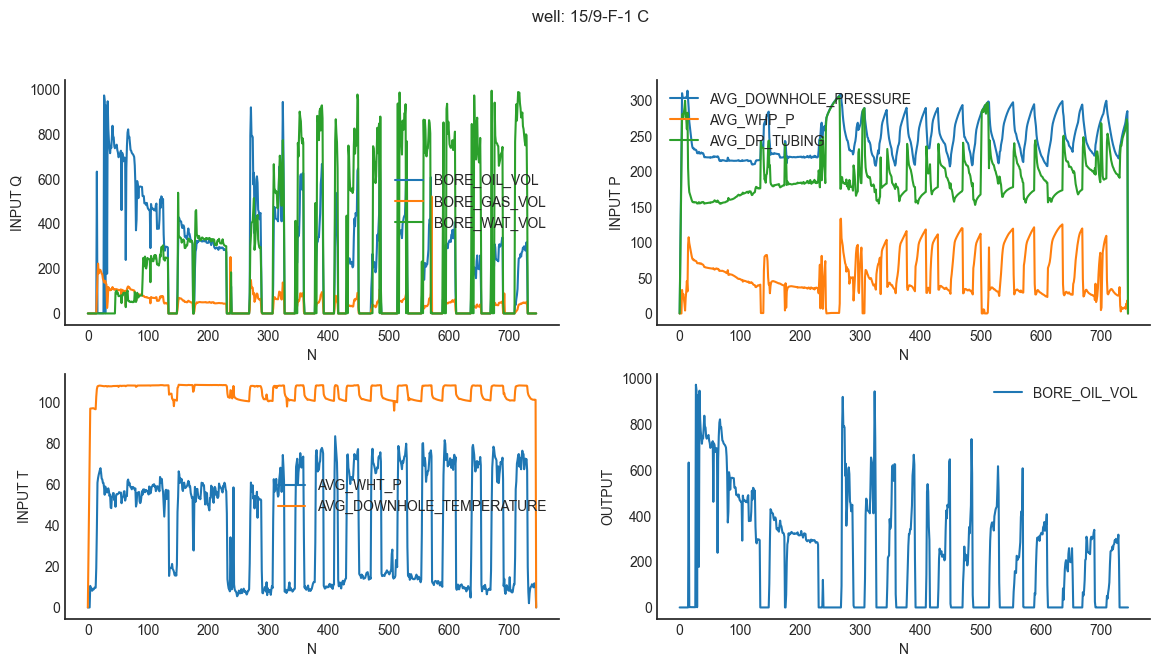

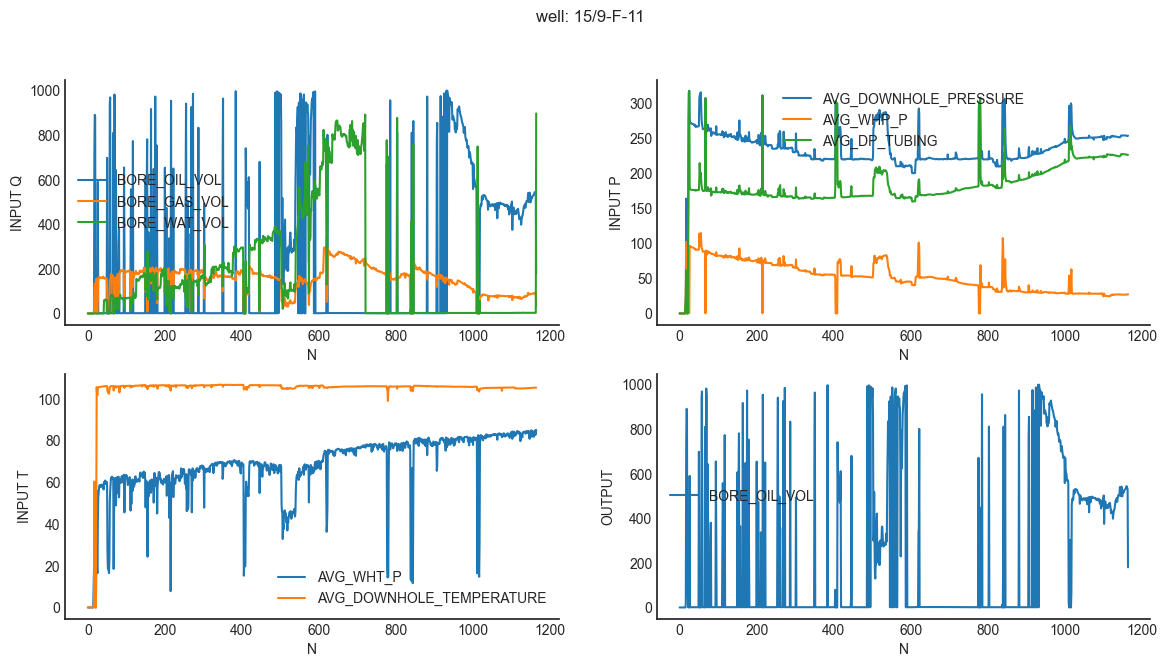

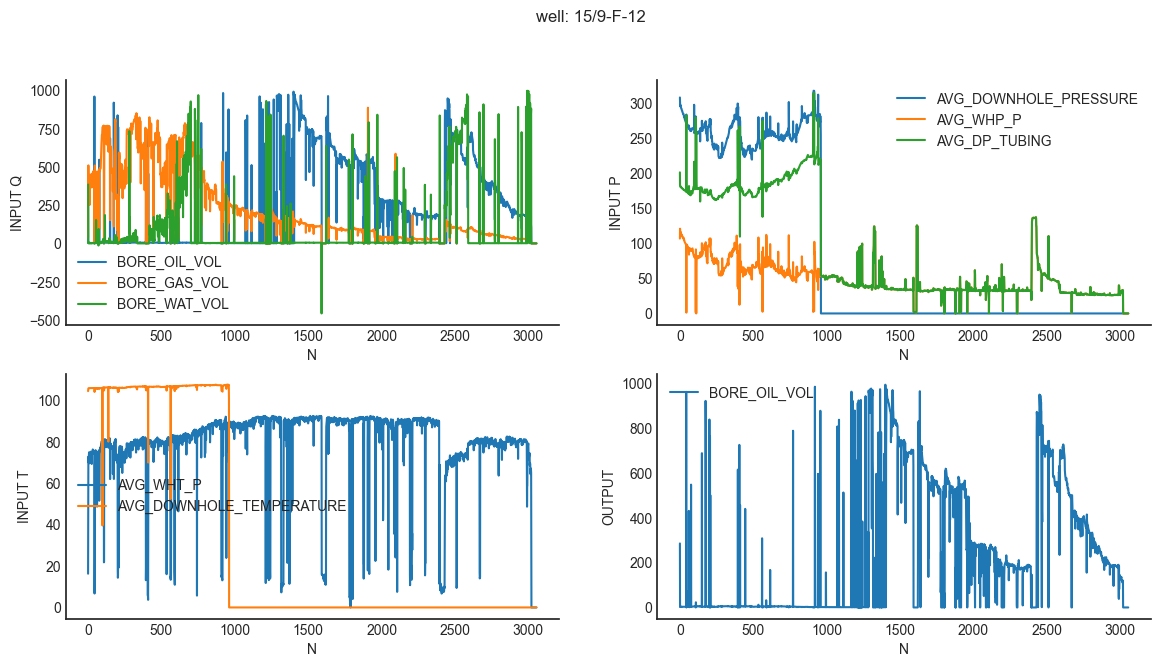

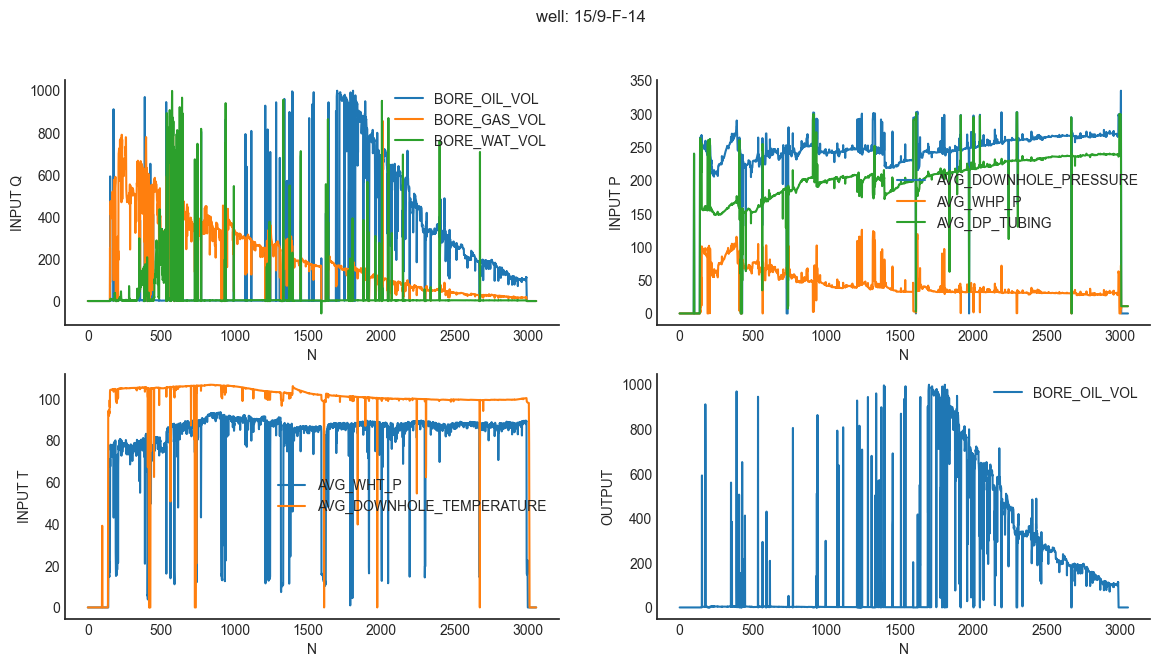

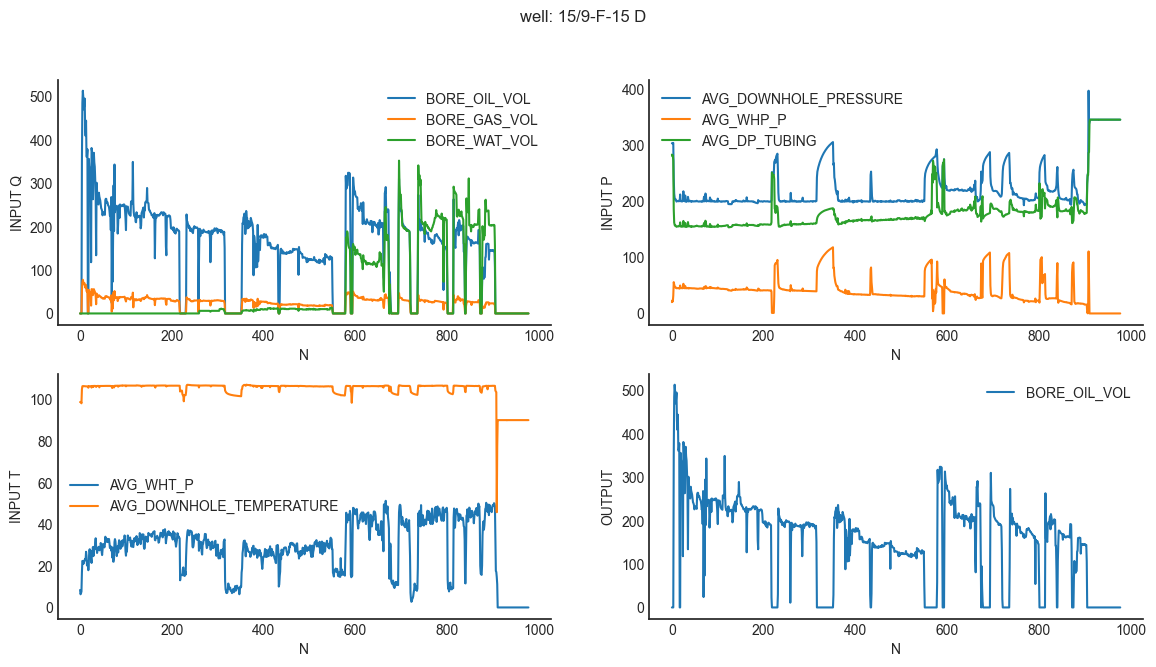

In [148]:
for well in pwells[:-1]:
    f, ax = plt.subplots(2,2,figsize=(14,7))
    for var in filt_vars_IN_Q:
        sns.lineplot(data=df[df['NPD_WELL_BORE_NAME'] == well], x='N', y=var, ax=ax[0,0], label=var)
    for var in filt_vars_IN_P:
        sns.lineplot(data=df[df['NPD_WELL_BORE_NAME'] == well], x='N', y=var, ax=ax[0,1], label=var)
    for var in filt_vars_IN_T:
        sns.lineplot(data=df[df['NPD_WELL_BORE_NAME'] == well], x='N', y=var, ax=ax[1,0], label=var)
    for var in filt_vars_OUT:
        sns.lineplot(data=df[df['NPD_WELL_BORE_NAME'] == well], x='N', y=var, ax=ax[1,1], label=var)

    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()
    ax[0,0].set_ylabel('INPUT Q')
    ax[0,1].set_ylabel('INPUT P')
    ax[1,0].set_ylabel('INPUT T')
    ax[1,1].set_ylabel('OUTPUT')

    plt.suptitle('well: '+well)
pass;

Filtragem

In [204]:
df_filt = df.dropna(subset=filt_vars_IN_P+filt_vars_IN_T)
df_filt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8980 entries, 0 to 9000
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DATEPRD                   8980 non-null   object 
 1   N                         8980 non-null   int64  
 2   month                     8980 non-null   int64  
 3   year                      8980 non-null   int64  
 4   month-year                8980 non-null   object 
 5   WELL_BORE_CODE            8980 non-null   object 
 6   NPD_WELL_BORE_CODE        8980 non-null   int64  
 7   NPD_WELL_BORE_NAME        8980 non-null   object 
 8   NPD_FIELD_CODE            8980 non-null   int64  
 9   NPD_FIELD_NAME            8980 non-null   object 
 10  NPD_FACILITY_CODE         8980 non-null   int64  
 11  NPD_FACILITY_NAME         8980 non-null   object 
 12  ON_STREAM_HRS             8980 non-null   float64
 13  AVG_DOWNHOLE_PRESSURE     8980 non-null   float64
 14  AVG_DOWN

Escolhe poço

In [205]:
w = 4

well = wells[w]
well

X1 = df_filt[df_filt['NPD_WELL_BORE_NAME'] == well][filt_vars_IN_P+filt_vars_IN_T].values
y = df_filt[df_filt['NPD_WELL_BORE_NAME'] == well][filt_vars_OUT].values 

X1.shape
y.shape

'15/9-F-15 D'

(978, 5)

(978, 1)

### 1.1 - Definindo a parcela de treino e de teste

In [206]:
p_train = .50 #50% treino

In [207]:
n_train = int(X1.shape[0]*p_train)

X1_tr = X1[:n_train,:]
y_tr = y[:n_train,:]
X1_te = X1[n_train:,:]
y_te = y[n_train:,:]

X1_tr.shape
X1_te.shape

(489, 5)

(489, 5)

ARMAX

In [208]:
na = 6
nb = 6
ne = 2

nb = [nb] * X1.shape[1]

model_ARMAX = FROLS(
    order_selection=True,
    ylag=na, xlag=nb,elag=ne,
    basis_function=Polynomial(degree=1),
    n_info_values=30,
    # n_terms=20,
    model_type='NARMAX',
    # extended_least_squares=True,
)


NARMAX

In [209]:
nl = 2
model_NARMAX = FROLS(
    order_selection=True,
    ylag=na, xlag=nb,elag=ne,
    basis_function=Polynomial(degree=nl),
    n_info_values=30,
    # n_terms=20,
    model_type='NARMAX',
    # extended_least_squares=True,
)

Fitting

In [210]:
model_NARMAX.fit(X=X1_tr, y=y_tr)
model_ARMAX.fit(X=X1_tr, y=y_tr)

c:\Users\bewm\AppData\Roaming\Python\env\env_sys\lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:476: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 12 
  self.info_values = self.information_criterion(reg_matrix, y)


In [211]:
r = pd.DataFrame(
    results(
        model_NARMAX.final_model, model_NARMAX.theta, model_NARMAX.err,
        model_NARMAX.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
r

,Regressors,Parameters,ERR
0,y(k-1),9.4414E-01,9.53148713E-01
1,y(k-3),-1.5433E-01,3.06752346E-03
2,x2(k-2),-1.0856E-03,2.11404903E-03
3,x5(k-3),1.3950E-03,3.48683657E-03
4,x2(k-6),2.2110E-04,7.62882587E-04
5,x5(k-4)y(k-1),2.3612E-02,6.37759965E-04
6,x2(k-3),-4.6100E-04,1.43840967E-04
7,y(k-6)y(k-1),1.5201E-04,3.37086963E-04


In [212]:
r = pd.DataFrame(
    results(
        model_ARMAX.final_model, model_ARMAX.theta, model_ARMAX.err,
        model_ARMAX.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
r

,Regressors,Parameters,ERR
0,y(k-1),7.8914E-01,9.53148713E-01
1,y(k-3),-4.0515E-02,3.06752346E-03
2,x1(k-3),-2.2347E-01,1.40406136E-03
3,y(k-2),7.5684E-02,2.45026663E-04
4,y(k-6),5.2062E-02,2.19942622E-04
5,x1(k-5),-8.4571E+00,1.70082704E-04
6,1,9.0964E+02,3.68985005E-04
7,x1(k-4),1.6387E+00,8.37280781E-04


OSA simulation

In [213]:
y_tr_pr_OSA_NARMAX = model_NARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=1)
y_te_pr_OSA_NARMAX = model_NARMAX.predict(X=X1_te, y=y_te,steps_ahead=1)

y_tr_pr_OSA_ARMAX = model_ARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=1)
y_te_pr_OSA_ARMAX = model_ARMAX.predict(X=X1_te, y=y_te,steps_ahead=1)

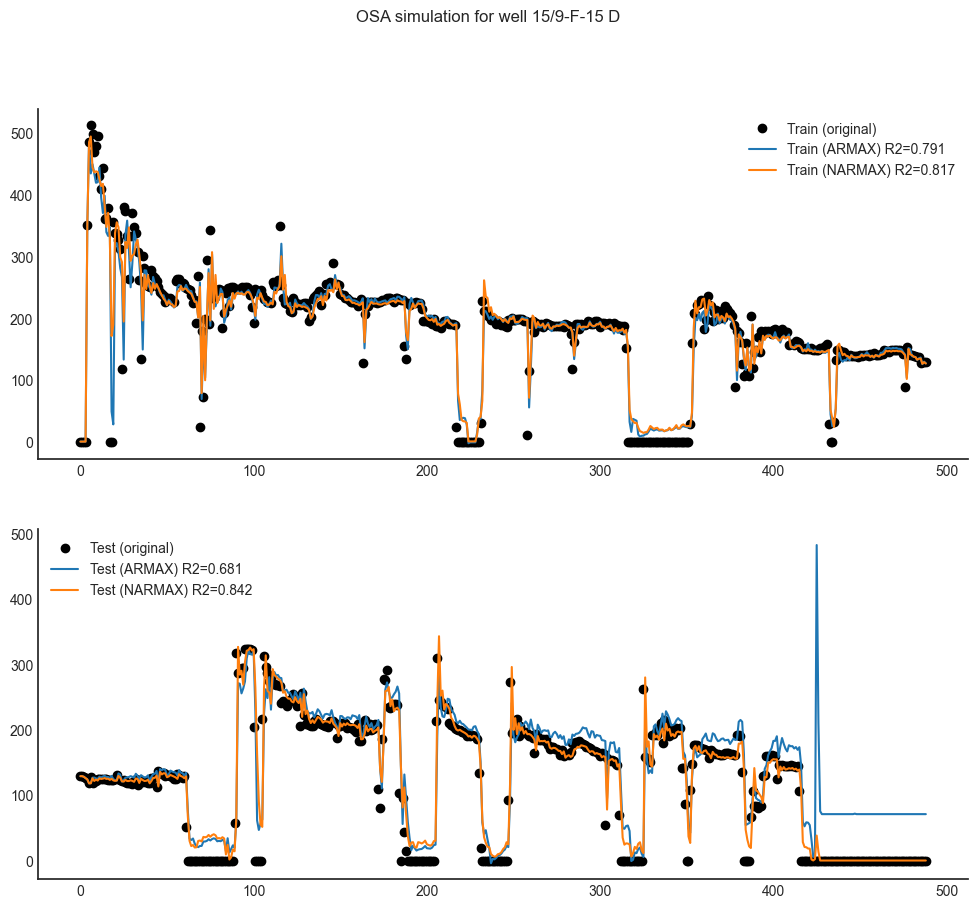

In [214]:
fig, ax = plt.subplots(2,1, figsize=(12,10))
ax[0].plot(y_tr, 'ko', label='Train (original)')
ax[0].plot(y_tr_pr_OSA_ARMAX, label=f'Train (ARMAX) R2={r2_score(y_tr, y_tr_pr_OSA_ARMAX):.3f}')
ax[0].plot(y_tr_pr_OSA_NARMAX, label=f'Train (NARMAX) R2={r2_score(y_tr, y_tr_pr_OSA_NARMAX):.3f}')
ax[1].plot(y_te, 'ko', label='Test (original)')
ax[1].plot(y_te_pr_OSA_ARMAX, label=f'Test (ARMAX) R2={r2_score(y_te, y_te_pr_OSA_ARMAX):.3f}')
ax[1].plot(y_te_pr_OSA_NARMAX, label=f'Test (NARMAX) R2={r2_score(y_te, y_te_pr_OSA_NARMAX):.3f}')
ax[0].legend()
ax[1].legend()
fig.suptitle('OSA simulation for well ' + wells[w])
pass;

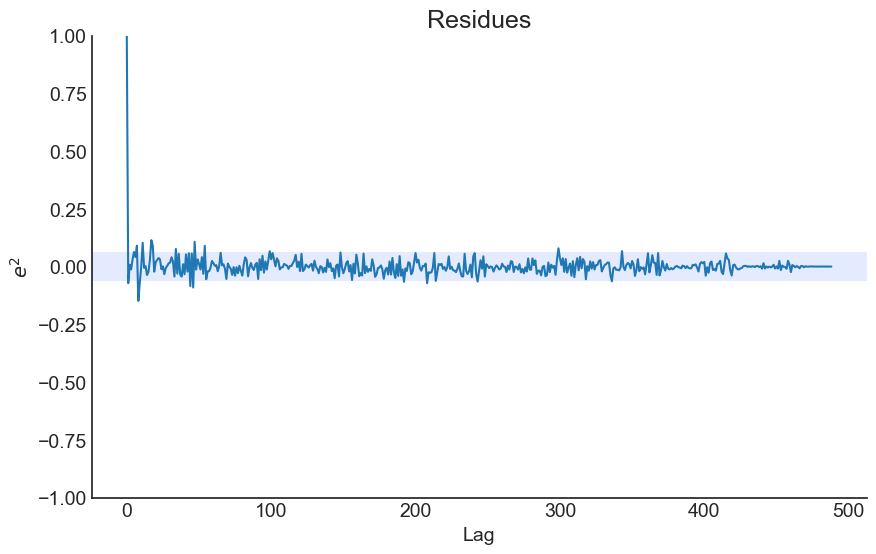

In [215]:
ee = compute_residues_autocorrelation(y_tr, y_tr_pr_OSA_NARMAX)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")

FR SIM

In [216]:
y_tr_pr_FS_NARMAX = model_NARMAX.predict(X=X1_tr, y=y_tr, steps_ahead=None)
y_te_pr_FS_NARMAX = model_NARMAX.predict(X=X1_te, y=y_te, steps_ahead=None)

y_tr_pr_FS_ARMAX = model_ARMAX.predict(X=X1_tr, y=y_tr, steps_ahead=None)
y_te_pr_FS_ARMAX = model_ARMAX.predict(X=X1_te, y=y_te, steps_ahead=None)

c:\Users\bewm\AppData\Roaming\Python\env\env_sys\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input contains NaN.

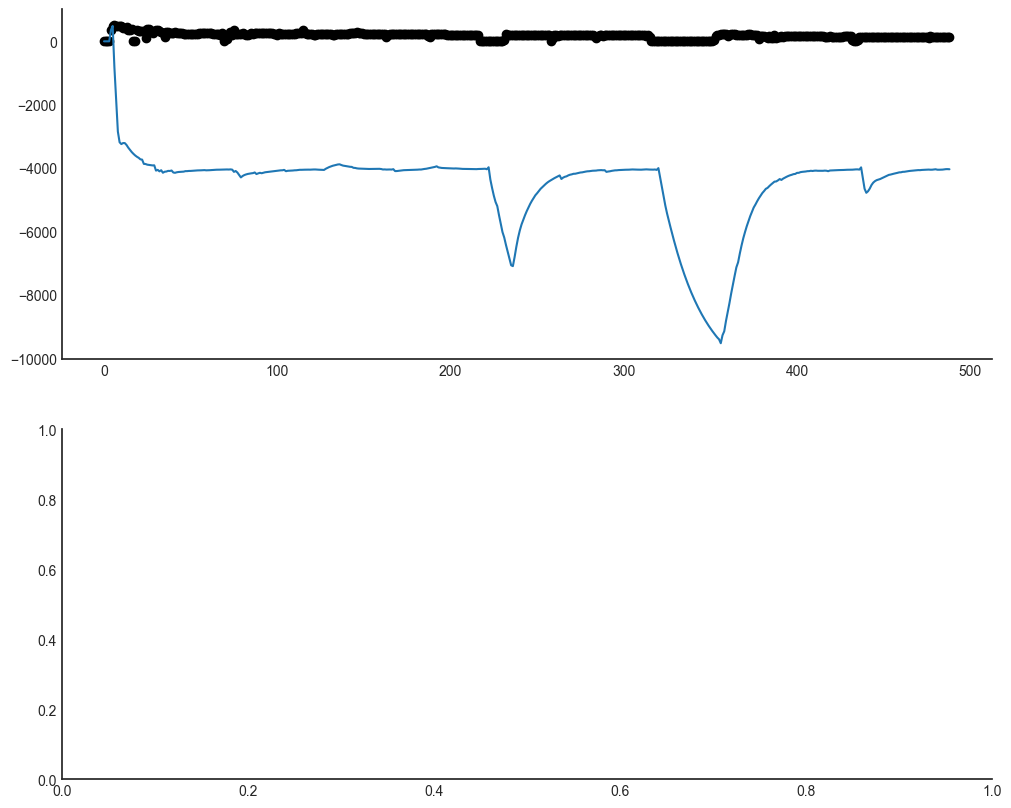

In [217]:
fig, ax = plt.subplots(2,1, figsize=(12,10))
ax[0].plot(y_tr, 'ko', label='Train (original)')
ax[0].plot(y_tr_pr_FS_ARMAX, label=f'Train (ARMAX) R2={r2_score(y_tr, y_tr_pr_FS_ARMAX):.3f}')
ax[0].plot(y_tr_pr_FS_NARMAX, label=f'Train (NARMAX) R2={r2_score(y_tr, y_tr_pr_FS_NARMAX):.3f}')
ax[1].plot(y_te, 'ko', label='Test (original)')
ax[1].plot(y_te_pr_FS_ARMAX, label=f'Test (ARMAX) R2={r2_score(y_te, y_te_pr_FS_ARMAX):.3f}')
ax[1].plot(y_te_pr_FS_NARMAX, label=f'Test (NARMAX) R2={r2_score(y_te, y_te_pr_FS_NARMAX):.3f}')
ax[0].legend()
ax[1].legend()
fig.suptitle('Free simulation for well ' + wells[w])
pass;